### ML 데이터 준비

- data__데이터전처리통합.ipynb 아래 코드에서 담당 카테고리의 변경사항 있을시 수정해서 사용

In [ ]:
def make_target(data):

    # 과거 또는 현재 흡연자만 도출
    if isinstance(data, pd.DataFrame):
        anal_data = data[~((data['sma_03z2'] > 3.0) & (data['sma_12z2'] > 2.0) & (data['sma_37z1'] > 3.0))].reset_index(drop=True)
    else:
        com_df = pd.read_csv(data)
        anal_data = com_df[~((com_df['sma_03z2'] > 3.0) & (com_df['sma_12z2'] > 2.0) & (com_df['sma_37z1'] > 3.0))].reset_index(drop=True)

    # 현재 흡연 여부. 하나라도 현재 피우고 있으면 흡연 중
    currently_smoking = (
        anal_data['sma_03z2'].isin([1, 2]) |
        (anal_data['sma_12z2'] == 1) |
        anal_data['sma_37z1'].isin([1, 2])
    )

    # 과거에 피웠으나 현재 피우지 않음
    stop_smoked = (
        (anal_data['sma_03z2'] == 3) |
        (anal_data['sma_12z2'] == 2) |
        (anal_data['sma_37z1'] == 3)
    )

    # 금연 성공자: 현재는 흡연 안 하고, 과거엔 피운 적 있음
    anal_data['churn'] = np.where(
        (~currently_smoking) & stop_smoked,
        1,
        0
    )

    return anal_data

In [1]:
# 라이브러리
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

# 환경설정
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)      # 행 전체 표시
pd.set_option('display.max_columns', None)  # 열 전체 표시
pd.set_option('display.width', None)        # 가로폭 자동 맞춤
pd.set_option('display.max_colwidth', None) # 셀 안의 텍스트 생략 방지
pd.set_option('display.float_format', '{:.6f}'.format)

# 경로 설정
ROOT_DIR = Path("").resolve().parent.parent

# 데이터 경로
DATA_DIR = ROOT_DIR / "data"
DATA_PATH = DATA_DIR / "analy_data.csv"
SAVE_FILE = "preprocessed_v1.csv"

# JSON 컬럼 관리 파일 로드
with open("modules/columns.json", "r", encoding="utf-8") as f:
    columns_dict = json.load(f)

# 공통 함수 
def get_columns(*categories):
    """columns.json의 카테고리별 use=y 컬럼 추출"""
    selected = []
    for cat in categories:
        for col, meta in columns_dict[cat].items():
            if meta.get("use", "n") == "y": 
                selected.append(col)
    
    if "churn" not in selected:
        selected.append("churn")

    if "exmprs_no" not in selected:
        selected.append("exmprs_no")

    return selected

def rename_to_kor(df):
    """columns.json의 name으로 한글 컬럼명 매핑"""
    rename_map = {
        col: meta["name"]
        for cat in columns_dict.values()
        for col, meta in cat.items()
        if col in df.columns
    }
    return df.rename(columns=rename_map)

# 1. 기본정보 + 가구조사 
def preprocess_basic_house(data_path):
    cols = get_columns("기본정보", "가구조사")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    if "CTPRVN_CODE" in df.columns:
        df['CTPRVN_CODE'] = df['CTPRVN_CODE'].apply(lambda x: x.split("'")[1])
    
    if "SPOT_NO" in df.columns:
        df['SPOT_NO'] = df['SPOT_NO'].apply(lambda x: x.split("'")[1])
    
    if "sex" in df.columns:
        df['sex'] = df['sex'].apply(lambda x: 1 if x == 1 else 2).astype(str)

    # NaN 변경
    for col in ["fma_04z1", "nue_01z1", "fma_27z1", "fma_26z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["fma_13z1", "fma_14z1"]:
        if col in df.columns:
            df.loc[df[col] >= 77777, col] = np.nan

    for col in ["fma_24z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 2. 식생활 + 비만및체중조절 + 구강건강
def preprocess_diet_obesity_oral(data_path):
    cols = get_columns("식생활", "비만및체중조절", "구강건강")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["nua_01z2", "nuc_02z1", "nuc_03z1", "obb_02a1", "obb_02b1", "obb_02d1", "ora_01z1", "orb_01z1", "ord_01d2", "ord_05z1", "ord_01f3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["ore_03z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 3. 음주 + 신체활동
def preprocess_drink_physical(data_path):
    cols = get_columns("음주", "신체활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # 값 변경
    if "drb_01z3" in df.columns:
        df["drb_01z3"] = df["drb_01z3"].replace(8, 1)

    if "drb_03z1" in df.columns:
        df["drb_03z1"] = df["drb_03z1"].replace(8, -1)

    # NaN 변경 
    for col in ["drb_01z3", "drb_03z1", "drg_01z3", "pha_11z1", "drb_04z1", "drb_05z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["pha_04z1", "pha_07z1", "phb_01z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 4. 정신건강 + 보건이용
def preprocess_mental_health(data_path):
    cols = get_columns("정신건강", "보건이용")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경 
    for col in ["mta_01z1", "mta_02z1", "mtc_08z1", "mtc_12c1", "mtc_12h1", "mtj_05z2", "mtj_10z1", "mtj_11z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["edit_mtc_03z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 5. 건강행태 + 교육및경제활동
def preprocess_behavior_education(data_path):
    cols = get_columns("건강행태", "교육및경제활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["smf_01z1", "sma_01z1", "sma_03z2", "smb_09z1", "sma_36z1", "sma_37z1", "sma_08z1", "sma_12z2"\
                "smd_02z3", "smd_01z3", "smc_08z2", "smc_09z2", "smc_10z2", "sob_02z1", "soa_01z1", "soa_07z1", "sod_02z3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["smb_02z1", "smb_05z1", "sma_11z2", "sob_01z1", "soa_06z2", "smb_12z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    for col in ["smb_01z1", "smb_13z1", "smb_03z1", "smb_04z1", "smb_06z1", "smb_11z1"]:
            if col in df.columns:
                df.loc[df[col] >= 777, col] = np.nan
    return df

df_basic = preprocess_basic_house(DATA_PATH)
df_health = preprocess_diet_obesity_oral(DATA_PATH)
df_drink = preprocess_drink_physical(DATA_PATH)
df_mental = preprocess_mental_health(DATA_PATH)
df_behavior = preprocess_behavior_education(DATA_PATH)

dfs = [df_basic, df_health, df_drink, df_mental, df_behavior]
df_merge = dfs[0]
for temp in dfs[1:]:
    join_cols = [c for c in ["exmprs_no", "churn"] if c in df_merge.columns and c in temp.columns]
    if join_cols:
        df_merge = pd.merge(df_merge, temp, on=join_cols, how="outer")

print("컬럼 식별 완료된 데이터 크기:", df_merge.shape,'-2')
print(f"결측치 비율: (평균) {df_merge.isna().mean().mean() * 100:.2f}%")

#=========================
# 추가 전처리
#=========================
# doyeon
#=========================
# '월간 폭음 경험(남)', '월간 폭음 경험(여)' ['drb_04z1', 'drb_05z1'] -> '월간 폭음 경험' ['drb_binge_monthly'] 통합
df_merge['sex'] = df_merge['sex']
df_merge['drb_binge_monthly'] = np.where(df_merge['sex'] == 1, df_merge['drb_04z1'], df_merge['drb_05z1'])
df_merge.drop(['drb_04z1', 'drb_05z1'], axis=1, inplace=True)

# 값변경
df_merge['drb_binge_monthly'] = df_merge['drb_binge_monthly'].replace(8, -1)
df_merge.loc[df_merge['drb_binge_monthly'] >= 7, 'drb_binge_monthly'] = np.nan

# 범주형 칼럼 object형 변환
df_merge['dra_01z1'] = df_merge['dra_01z1'].astype('object')

#=========================
# soso
#=========================
# 연령대
df_merge['age_group'] = (df_merge['age'] // 10) * 10

# 1인가구
df_merge['is_single'] = np.where((df_merge['mbhld_co'] <= 1), 1, 0)

# 월간소득 기준 가구소득컬럼 통합
df_merge['fma_14z1_add'] = df_merge['fma_14z1'] 
df_merge['fma_14z1_add'] = round(df_merge['fma_14z1_add'].fillna(df_merge['fma_13z1'] / 12))
df_merge['fma_14z1_log'] = np.log1p(df_merge['fma_14z1_add'])

bins = [0, 50, 100, 200, 300, 400, 500, 600, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
df_merge['fma_14z1_group'] = pd.cut(df_merge['fma_14z1_add'], bins=bins, labels=labels, right=False)
df_merge['fma_14z1_group'] = np.where(df_merge['fma_14z1_group'].isna(), df_merge['fma_24z2'].astype(float), df_merge['fma_14z1_group'])

# 치매가족여부
def get_dementia_case(row):
    if row['fma_27z1'] == 1 and row['fma_26z1'] == 1:
        return 1 # 치매가족 있음 + 같이 거주
    elif row['fma_27z1'] == 1 and row['fma_26z1'] == 2:
        return 2 # 치매가족 있음 + 비거주
    elif row['fma_27z1'] == 2:
        return 3 # 치매가족 없음
    else:
        return np.nan

df_merge['fma_dementia_case'] = df_merge.apply(get_dementia_case, axis=1)

# 일반담배일평균(단위: 개비)
df_merge['smb_avg_per_day'] = df_merge.apply(lambda x : x[['smb_01z1', 'smb_03z1', 'smb_06z1']].max(skipna=True), axis=1)

# 컬럼 삭제
df_merge.drop(['fma_13z1', 'fma_14z1','fma_27z1','fma_26z1','smb_01z1','smb_03z1','smb_06z1'], axis=1, inplace=True)

print("추가 전처리 후 데이터 크기:", df_merge.shape ,'-2')
print("exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용")

컬럼 식별 완료된 데이터 크기: (89822, 61) -2
결측치 비율: (평균) 26.31%
추가 전처리 후 데이터 크기: (89822, 60) -2
exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용


In [2]:
# 금연여부에 상관없이 들어오는 데이터만 활용

---

### 모델에 들어가는 피처 핸들링하고 테스트 해보기 (포맷 고정)

In [3]:
# 위 코드 실행 결과: df_merge
df_pre = df_merge.copy()
df_pre = df_pre.drop(['exmprs_no'], axis=1)

# 최종 피처 선택
fnl_col = df_pre.columns.tolist()
df = df_pre[fnl_col]

df_merge_kor = rename_to_kor(df)
df_merge_kor

,만나이,성별,시도번호,가구원수_전체,기초생활수급자여부,월간가구총소득구간,가구식품안정성여부,이탈여부,아침식사빈도,영양표시설인지여부,영양표시영향여부,체중조절방법_운동,체중조절방법_단식,체중조절방법_무처방약물,구강건강자기평가,저작불편여부,점심후양치여부,점심후양치불가이유,저녁양치여부,치과미수진이유,평생 음주 여부,연간 음주 빈도,한 번 섭취 시 음주량,절주 또는 금주계획 여부,고강도 신체활동 일수,중강도 신체활동 일수,걷기 실천 일수,최근 1주일 유연성 운동 실천,스트레스정도,스트레스상담여부,취침시간,기상시간,화장실각성여부,악몽경험여부,기억력저하여부,상담여부,치매검사여부,일반담배평생흡연량,궐련형전자담배평생사용,궐련형매일사용자하루사용량,궐련형가끔사용자일평균사용량,액상형전자담배평생사용,가정내흡연자존재,가정간접흡연노출,직장간접흡연노출,교육수준,졸업상태,경제활동여부,직업분류,종사상지위,혼인상태,drb_binge_monthly,age_group,is_single,fma_14z1_add,fma_14z1_log,fma_14z1_group,fma_dementia_case,smb_avg_per_day
0,31.000000,1,11,1.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,1.000000,2.000000,2.000000,3.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,3.000000,1.000000,2.000000,2.000000,5.000000,3.000000,2.000000,2.000000,0.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,1.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,5.000000,NaN,30.000000,1,1000.000000,6.908755,8.000000,3.000000,1.000000
1,37.000000,1,11,3.000000,3.000000,NaN,1.000000,0,2.000000,1.000000,1.000000,NaN,NaN,NaN,2.000000,5.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,7.000000,1.000000,4.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,2.000000,5.000000,1.000000,1.000000,4.000000,2.000000,1.000000,NaN,30.000000,0,300.000000,5.707110,5.000000,3.000000,15.000000
2,36.000000,2,11,3.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,2.000000,2.000000,2.000000,2.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,4.000000,2.000000,0.000000,4.000000,7.000000,1.000000,2.000000,2.000000,1.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,2.000000,6.000000,1.000000,1.000000,4.000000,2.000000,1.000000,4.000000,30.000000,0,300.000000,5.707110,5.000000,3.000000,10.000000
3,36.000000,1,11,2.000000,3.000000,NaN,1.000000,0,4.000000,1.000000,NaN,1.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,0.000000,3.000000,5.000000,1.000000,2.000000,2.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,1.000000,NaN,30.000000,0,667.000000,6.504288,8.000000,3.000000,10.000000
4,64.000000,1,11,1.000000,1.000000,NaN,4.000000,0,2.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,NaN,1.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,22.000000,6.000000,4.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,3.000000,3.000000,3.000000,2.000000,NaN,NaN,5.000000,NaN,60.000000,1,50.000000,3.931826,2.000000,3.000000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89817,49.000000,1,50,1.000000,3.000000,NaN,1.000000,1,4.000000,1.000000,NaN,NaN,NaN,NaN,4.000000,3.000000,1.000000,NaN,1.000000,NaN,1.000000,4.000000,1.000000,1.000000,1.000000,5.000000,7.000000,1.000000,4.000000,NaN,22.000000,NaN,1.000000,1.000000,2.000000,NaN,NaN,2.000000,1.000000,NaN,NaN,1.000000,2.000000,NaN,2.000000,7.000000,3.000000,1.000000,2.000000,1.000000,2.000000,NaN,40.000000,1,417.000000,6.035481,6.000000,3.000000,20.000000
89818,77.000000,1,50,5.000000,3.000000,NaN,1.000000,1,1.000000,1.000000,NaN,NaN,NaN,NaN,3.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,-1.000000,NaN,0.000000,3.000000,6.000000,1.000000,3.000000,NaN,22.000000,5.000000,2.000000,1.000000,2.000000,NaN,2.000000,2.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,3.000000,5.000000,1.000000,2.000000,NaN,NaN,1.000000,NaN,70.000000,0,583.000000,6.369901,7.000000,3.000000,20.000000
89819,64.000000,1,50,3.000000,3.000000,NaN,1.000000,1,1.000000,1.000000

In [ ]:
df = df_merge_kor.copy()
if 'churn' in df.columns: TARGET_NM = 'churn'
else: TARGET_NM = '이탈여부'

# 모델
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분리
X = df.drop(TARGET_NM, axis=1)
X[X.select_dtypes(exclude=['number']).columns] = X.select_dtypes(exclude=['number']).astype(float)
y = df[TARGET_NM]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')

# 파라미터 후보
param_grid = {
    'max_depth': [3, 5, 7, 10, -1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV 설정
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=2),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)

# 최적 모델
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# 평가
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# # 모델 학습
# model = DecisionTreeClassifier(random_state=2)
# # model = LGBMClassifier(
# #     n_estimators=100,
# #     learning_rate=0.1,
# #     max_depth=-1,
# #     random_state=2,
# #     verbose=1
# # )

# model.fit(X_train, y_train)

# # 예측 및 평가
# y_pred = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))

# # 변수중요도
# feature_importance = pd.Series(model.feature_importances_, index=X.columns)
# print(feature_importance.sort_values(ascending=False), '\n')

# # 혼동행렬
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

# # ROC-AUC
# y_prob = model.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_prob)
# fpr, tpr, _ = roc_curve(y_test, y_prob)

# # PR-AUC
# pr_auc = average_precision_score(y_test, y_prob)
# prec, recall, _ = precision_recall_curve(y_test, y_prob)

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# axes[0].plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
# axes[0].plot([0,1],[0,1],'--')
# axes[0].set_xlabel("FPR")
# axes[0].set_ylabel("TPR")
# axes[0].set_title("ROC Curve")
# axes[0].legend()

# axes[1].plot(recall, prec, label=f"PR-AUC = {pr_auc:.3f}")
# axes[1].set_xlabel("Recall")
# axes[1].set_ylabel("Precision")
# axes[1].set_title("Precision-Recall Curve")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

(71857, 58) (71857,) (17965, 58) (17965,) 

Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.7170351302197077
Test Accuracy: 0.7151127191761759


Accuracy: 0.7151127191761759
궐련형전자담배평생사용         0.310827
만나이                 0.139734
smb_avg_per_day     0.076274
혼인상태                0.074235
일반담배평생흡연량           0.060786
궐련형매일사용자하루사용량       0.055038
체중조절방법_운동           0.045135
궐련형가끔사용자일평균사용량      0.038135
한 번 섭취 시 음주량        0.027705
직업분류                0.020235
아침식사빈도              0.015838
교육수준                0.013440
구강건강자기평가            0.010856
연간 음주 빈도            0.010600
체중조절방법_무처방약물        0.010047
평생 음주 여부            0.008775
최근 1주일 유연성 운동 실천    0.007019
fma_14z1_add        0.005174
fma_14z1_log        0.004892
걷기 실천 일수            0.004549
기상시간                0.003753
체중조절방법_단식           0.003634
취침시간                0.003157
age_group           0.002983
화장실각성여부             0.002785
가정간접흡연노출            0.002609
치과미수진이유             0.002583
점심후양치여부             0.002507
저작불편여부              0.002466
시도번호                0.002463
drb_binge_monthly   0.002408
절주 또는 금주계획 여부       0.002401
직장간접흡연노출            0.002334
성별            

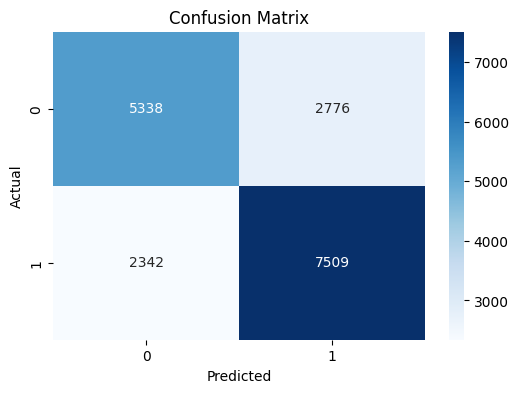

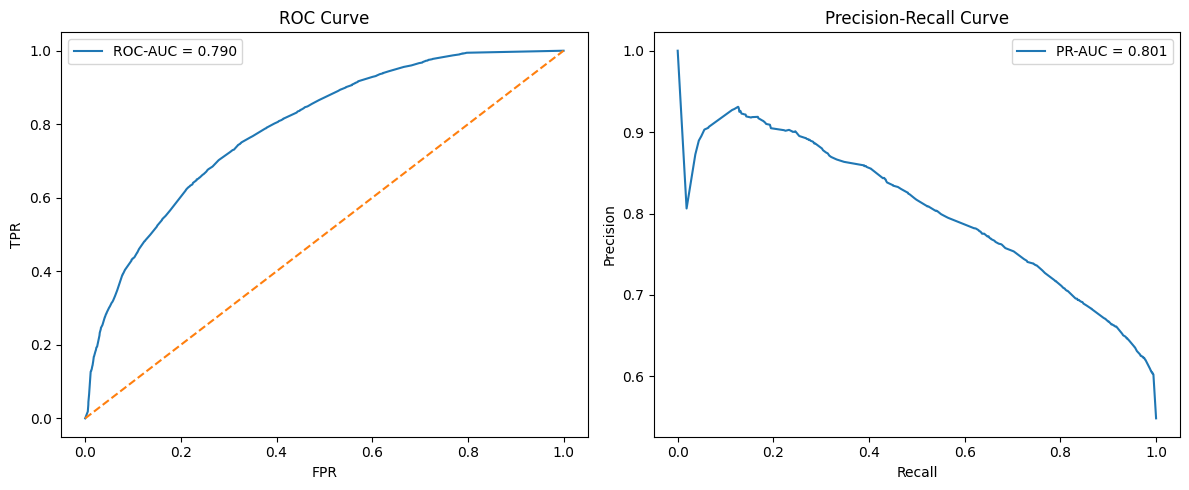

In [93]:
# 예측 및 평가
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# 변수중요도
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
print(feature_importance.sort_values(ascending=False), '\n')

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
prec, recall, _ = precision_recall_curve(y_test, y_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
axes[0].plot([0,1],[0,1],'--')
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC Curve")
axes[0].legend()

axes[1].plot(recall, prec, label=f"PR-AUC = {pr_auc:.3f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# 권렬형담배사용자 흡연여부
df_merge_kor.groupby('궐련형전자담배평생사용')['이탈여부'].agg({'mean','count'}) # 전자담배는 금연에 도움이 안됨

,mean,count
궐련형전자담배평생사용,,
1.000000,0.207278,16104
2.000000,0.622843,73712


In [98]:
df_merge_kor['궐련형전자담배평생사용'].isnull().sum()

np.int64(6)

In [ ]:
df_merge_kor.groupby('만나이')['이탈여부'].agg({'mean','count'})
df_merge_kor.groupby('smb_avg_per_day')['이탈여부'].agg({'mean','count'})
df_merge_kor.groupby('혼인상태')['이탈여부'].agg({'mean','count'})
# ① 배우자 있으며, 함께 살고 있다(사실혼 포함)
# ② 배우자 있으나, 함께 살고 있지 않는다(출장 등의 일시적 상태 제외)
# ③ 배우자 사망으로 배우자가 없다 >> 나이대 고령예상
# ④ 이혼으로 배우자가 없다
# ⑤ 미혼으로 배우자가 없다

,mean,count
혼인상태,,
1.000000,0.617635,59608
2.000000,0.518530,3184
3.000000,0.638484,4116
4.000000,0.399033,7240
5.000000,0.336016,15657


In [ ]:
# fnl_col = [
# '만나이',
# '성별',
# 'age_group',
# 'fma_14z1_add',
# 'fma_14z1_log',
# 'fma_14z1_group',
# 'is_single',
# 'fma_dementia_case',
# 'drb_binge_monthly',
# '고강도 신체활동 일수',
# '스트레스정도',
# '평생 음주 여부',
# '절주 또는 금주계획 여부',
# '이탈여부'
# ]

# DecisionTree, RandomForest, LogisticRegression, LightGBM, XGBoost
# models = []
# results = {}
# for m in models:
#     m.train(X_train, y_train)
#     results[m.model_name] = m.evaluate(X_test, y_test)

# for name, metrics in results.items():
#     print(name, metrics)

# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt
# plt.figure(figsize=(40, 20), dpi=200) 
# plot_tree(model, 
#           feature_names=X.columns, 
#           class_names=['금연실패', '금연성공'],
#           filled=True, 
#           rounded=True,
#           fontsize=8,
#           max_depth=4)
# plt.show()

# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred, target_names = ["F", "T"]))